# Initial test runs
This experiments seeks to test whether CALVADOS 2 is viable for simulating histone IDRs.

In [1]:
# Imports
import sys
import json
import pandas as pd
import os
import mdtraj as md
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

sys.path.append('../../src')
import data_utils
import analyse_utils

## Data preparation

### Templates

In [3]:
# Defining UniProt IDs / Trivial IDs
entries = {
    'H1-0': 'P07305',
    'H2B': 'B4DR52'
}
templates = pd.DataFrame({'uniprot_id': entries.values(),
                          'name': None,
                          'description': None,
                          'species': None,
                          'sequence': None},
                          index=entries.keys())

In [53]:
# Collecting metadata
for id, row in templates.iterrows():
    name, desc, spec, seq = data_utils.get_protein_metadata(row.uniprot_id)
    templates.loc[id] = {
        'uniprot_id': row.uniprot_id,
        'name': name,
        'description': desc,
        'species': spec,
        'sequence': seq}

2it [00:00,  5.18it/s]


In [60]:
# Viewing final templates
templates

,uniprot_id,name,description,species,sequence
H1-0,P07305,H10_HUMAN,Histone H1.0,Homo sapiens (Human),MTENSTSAPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSS...
H2B,B4DR52,B4DR52_HUMAN,Histone H2B,Homo sapiens (Human),MPDPAKSAPAPKKGSKKAVTKVQKKDGKKRKRSRKESYSVYVYKVL...


In [61]:
# Saving metadata
metadata = {'templates': templates.to_dict(orient='index')}
with open('initial.json', 'w') as file:
    json.dump(metadata, file, indent=4)

### Variants

In [6]:
# Getting template metadata
with open('initial.json', 'r') as file:
    metadata = json.load(file)

In [7]:
# Getting longest IDR
length_order=True
i_idr=0

In [8]:
# Getting IDR regions
IDRs = []
for id, fields in metadata['templates'].items():
    seq, loc, reg = data_utils.get_protein_idr(uniprot_id=fields['uniprot_id'], i_idr=i_idr, length_order=length_order)
    IDRs.append({'template': id, 'sequence': seq, 'location': loc, 'region': reg})
data = pd.DataFrame(IDRs)

  0%|          | 0/2 [00:00<?, ?it/s]/storage1/fknudsen/software/miniconda3/envs/orthoidp/lib/python3.10/site-packages/Bio/SeqFeature.py:1940: BiopythonDeprecationWarning: Alias location.position is deprecated and will be removed in a future release. Use location directly, or int(location). However, that will fail for UnknownPosition, and for OneOfPosition and WithinPosition will give the default rather than left-most value.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


In [9]:
# Expanding dataframe to include all variants
data['variant'] = [data_utils.variant_types.keys()]*len(data)
data = data.explode('variant')
data.index = data['template'] + '_' + data['variant'].str.upper()

# Generating variant sequence
data['sequence'] = data.apply(lambda row: data_utils.generate_variant(row['sequence'], row['variant']), axis=1)

# Setting variant description
data['variant'] = data.apply(lambda row: data_utils.variant_types[row['variant']]['name'], axis=1)

In [10]:
# Viewing final data
data

,template,sequence,location,region,variant
H1-0_WT,H1-0,TKGVGASGSFRLAKSDEPKKSVAFKKTKKEIKKVATPKKASKPKKA...,83:194,CTD,Wild type
H1-0_RAND,H1-0,SGKKSAITKPKKKASFRSKAVAPPAAKKKKSAAKKAGKLFDSKKVK...,83:194,CTD,Randomly shuffled
H1-0_CLUST,H1-0,KKKKKKKKKKRKKKRKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKA...,83:194,CTD,Terminally clustered charges
H2B_WT,H2B,MPDPAKSAPAPKKGSKKAVTKVQKKDGKKRKRSRKE,0:36,NTD,Wild type
H2B_RAND,H2B,PTKGDPRPVGKEDSKKKAPSRKKAVKQAKAKKSMRK,0:36,NTD,Randomly shuffled
H2B_CLUST,H2B,KRKKKKRKKKKKKRKMPAVTSVQAASGPAPPGSDDE,0:36,NTD,Terminally clustered charges


In [ ]:
# Saving sequences
os.makedirs('data', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Iterating over rows
for index, cols in data.iterrows():
    id = index.upper()
    desc = cols['variant']
    seq = cols['sequence']

    # Saving as FASTA format (Though one-line sequence)
    filepath = 'data/' + id + '.fasta'
    with open(filepath, 'w') as file:
        file.write('>' + id + ' ' + desc + '\n')
        file.write(seq + '\n')

In [ ]:
# Saving metadata
metadata['data'] = data.to_dict(orient='index')
with open('initial.json', 'w') as file:
    json.dump(metadata, file, indent=4)

## Analysis

In [5]:
# Loading metadata
metadata = analyse_utils.load_metadata('initial.json')
metadata

,template,sequence,location,region,variant,uniprot_id,description,name,species
H1-0_WT,H1-0,TKGVGASGSFRLAKSDEPKKSVAFKKTKKEIKKVATPKKASKPKKA...,83:194,CTD,Wild type,P07305,Histone H1.0,H10_HUMAN,Homo sapiens (Human)
H1-0_RAND,H1-0,PGTKKPKSTKTKKALAKAKKAKVKGSKAEKATSAAKKSVKPKKSKA...,83:194,CTD,Randomly shuffled,P07305,Histone H1.0,H10_HUMAN,Homo sapiens (Human)
H1-0_CLUST,H1-0,KKKKKKKKKKRKKKKKKKKKKKKKKKKKKKKKRKKKKKKKKKKKKA...,83:194,CTD,Terminally clustered charges,P07305,Histone H1.0,H10_HUMAN,Homo sapiens (Human)
H2B_WT,H2B,MPDPAKSAPAPKKGSKKAVTKVQKKDGKKRKRSRK,0:36,NTD,Wild type,B4DR52,Histone H2B,B4DR52_HUMAN,Homo sapiens (Human)
H2B_RAND,H2B,EKKKKSDMKPKRKPVASQAAKPKSRKKKTPGRGAA,0:36,NTD,Randomly shuffled,B4DR52,Histone H2B,B4DR52_HUMAN,Homo sapiens (Human)
H2B_CLUST,H2B,RKRKKKKKKKRKKKKASAVTAAQGPPGSAPPMSED,0:36,NTD,Terminally clustered charges,B4DR52,Histone H2B,B4DR52_HUMAN,Homo sapiens (Human)


In [3]:
# Loading trajectories
metadata['traj'] = metadata.apply(lambda row: md.load_dcd(*['/'.join(['results', row.name, filename]) for filename  in ['traj.dcd', 'top.pdb']]), axis=1)

In [129]:
plt.rcParams["font.family"] = "Liberation Sans"
plt.rcParams["font.weight"] = "normal"

### Composition

In [3]:
# Calculating amino acid compositions
freqs = analyse_utils.amino_acid_content(metadata.sequence)

/tmp/ipykernel_19112/2550527364.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  patches, texts, autotexts  = ax.pie(data, autopct='%1.1f%%', labels=data.index, startangle=90, colors=get_cmap('Reds_r')(np.linspace(0,1,len(data))))


Text(0.5, 1.0, 'Amino acid composition')

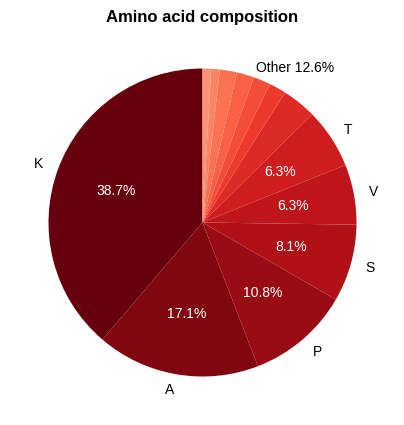

In [131]:
# Plotting distributions for H1.0
from matplotlib.cm import get_cmap
fig, ax = plt.subplots(figsize=(5, 5))
data = freqs.loc['H1-0_WT'].sort_values(ascending=False)
patches, texts, autotexts  = ax.pie(data, autopct='%1.1f%%', labels=data.index, startangle=90, colors=get_cmap('Reds_r')(np.linspace(0,1,len(data))))

other = []
for f, text, autotext in zip(data, texts, autotexts):
    autotext.set_color('white')
    if f < 0.05:
        text.set_visible(False)
        autotext.set_visible(False)
        other.append((f, text, autotext))

other_x = (other[0][1].get_position()[0] + other[-1][1].get_position()[0])/2
other_y = (other[0][1].get_position()[1] + other[-1][1].get_position()[1])/2
other_pct = sum([float(aa[2].get_text()[:-1])/100 for aa in other])
ax.text(other_x, other_y, f"Other {other_pct:.1%}")

ax.set_title("Amino acid composition", fontweight='bold')

In [19]:
111 * freqs.astype(float)

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
H1-0_WT,19.000000,0.0,1.000000,2.000000,2.0,4.000000,0.0,1.0,43.000000,2.0,0.000000,0.0,12.000000,0.000000,2.000000,9.000000,7.000000,7.000000,0.0,0.0
H1-0_RAND,19.000000,0.0,1.000000,2.000000,2.0,4.000000,0.0,1.0,43.000000,2.0,0.000000,0.0,12.000000,0.000000,2.000000,9.000000,7.000000,7.000000,0.0,0.0
H1-0_CLUST,19.000000,0.0,1.000000,2.000000,2.0,4.000000,0.0,1.0,43.000000,2.0,0.000000,0.0,12.000000,0.000000,2.000000,9.000000,7.000000,7.000000,0.0,0.0
H2B_WT,12.685714,0.0,6.342857,0.000000,0.0,6.342857,0.0,0.0,38.057143,0.0,3.171429,0.0,12.685714,3.171429,9.514286,9.514286,3.171429,6.342857,0.0,0.0
H2B_RAND,15.857143,0.0,3.171429,3.171429,0.0,6.342857,0.0,0.0,38.057143,0.0,3.171429,0.0,12.685714,3.171429,9.514286,9.514286,3.171429,3.171429,0.0,0.0
H2B_CLUST,15.857143,0.0,3.171429,3.171429,0.0,6.342857,0.0,0.0,38.057143,0.0,3.171429,0.0,12.685714,3.171429,9.514286,9.514286,3.171429,3.171429,0.0,0.0


### CIDER parameters

More on CIDER from Pappu Lab:
- [CIDER](http://pappulab.wustl.edu/CIDER/about/)
- [localCIDER](http://pappulab.github.io/localCIDER/)

In [6]:
# Calculating parameters
cider = analyse_utils.cider_parameters(metadata['sequence'])
cider['Length'] = metadata.sequence.str.len()
cider['Charge'] = (cider.Length * cider.NCPR).astype(int)

cider

,kappa,FCR,NCPR,Hydrophobicity,Frac. dis. prom.,Length,Charge
H1-0_WT,0.154432,0.432432,0.378378,3.249550,0.891892,111,42
H1-0_RAND,0.217323,0.432432,0.378378,3.249550,0.891892,111,42
H1-0_CLUST,0.994959,0.432432,0.378378,3.249550,0.891892,111,42
H2B_WT,0.301676,0.485714,0.371429,2.682857,0.914286,35,13
H2B_RAND,0.299729,0.485714,0.371429,2.614286,0.942857,35,13
H2B_CLUST,0.965685,0.485714,0.371429,2.614286,0.942857,35,13


### Structural descriptors

In [144]:
struc = pd.DataFrame(index=metadata.index)

In [145]:
# Computing radius of gyration
struc['Rg'] = metadata.apply(lambda row: analyse_utils.compute_rg(row.traj), axis=1)
struc['<Rg>'] = struc.apply(lambda row: row.Rg.mean(), axis=1)

In [7]:
# Computing end-to-end distance
struc['Re'] = metadata.apply(lambda row: analyse_utils.compute_end_to_end(row.traj), axis=1)
struc['<Re>'] = struc.apply(lambda row: row.Re.mean(), axis=1)

In [175]:
# Computing asphericity
struc['Delta'] = metadata.apply(lambda row: analyse_utils.compute_asphericity(row.traj), axis=1)
struc['<Delta>'] = struc.apply(lambda row: row.Delta.mean(), axis=1)

In [176]:
# Computing prolateness
struc['S'] = metadata.apply(lambda row: analyse_utils.compute_prolateness(row.traj), axis=1)
struc['<S>'] = struc.apply(lambda row: row.Delta.mean(), axis=1)

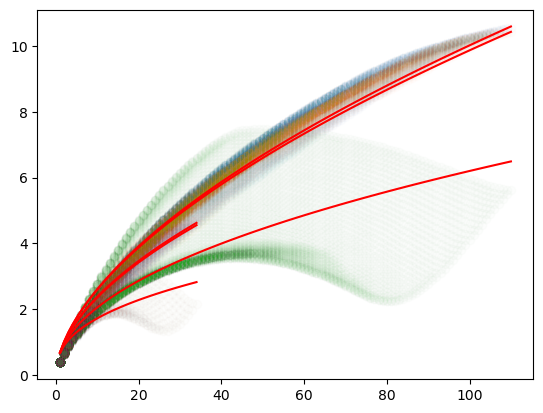

In [10]:
# Computing scaling exponent
struc['v'] = metadata.apply(lambda row: analyse_utils.compute_scaling_exponent(row.traj, plot=True, r0_fix=0.68, ij_cutoff=10)[0], axis=1)

In [11]:
# Displaying means
struc[[*struc.columns[struc.columns.str.contains('<')], 'v']]

,<Rg>,<Re>,<Delta>,<S>,v
H1-0_WT,4.238790,10.555419,0.200731,0.200731,0.584180
H1-0_RAND,4.192001,10.439872,0.202048,0.202048,0.580877
H1-0_CLUST,2.985130,5.635416,0.152445,0.152445,0.480004
H2B_WT,1.885571,4.734719,0.211185,0.211185,0.543716
H2B_RAND,1.837662,4.583144,0.210836,0.210836,0.539363
H2B_CLUST,1.374362,2.148254,0.141250,0.141250,0.403844


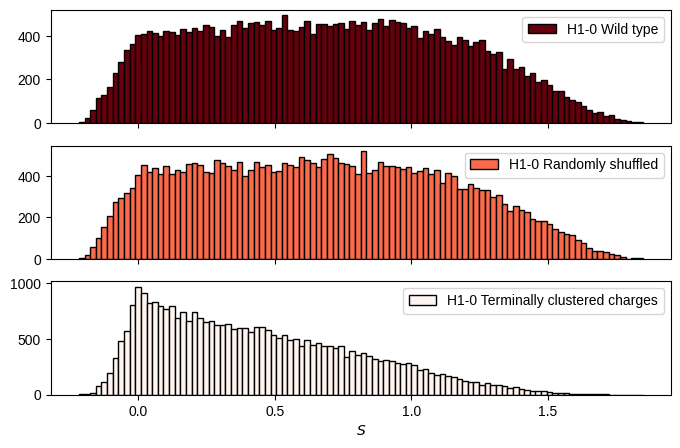

In [178]:
# Plotting distributions
measure = 'S'
axes = struc[[measure]].transpose().explode([*struc.index]).astype(float).plot.hist(bins=100, subplots=True, figsize=(8,5), cmap="Reds_r", edgecolor='black')
for i, ax in enumerate(axes):
    ax.set_ylabel(None)
    ax.legend([(metadata.template + ' ' + metadata.variant)[i]])
    if i == len(axes) - 1:
        ax.set_xlabel("$S$")

#### MDTraj

In [132]:
# Computing asphericity
struc['b'] = metadata.apply(lambda row: md.asphericity(row.traj), axis=1)
struc['<b>'] = struc.apply(lambda row: row.b.mean(), axis=1)

In [138]:
# Computing acylindricity
struc['c'] = metadata.apply(lambda row: md.acylindricity(row.traj), axis=1)
struc['<c>'] = struc.apply(lambda row: row.c.mean(), axis=1)

In [ ]:
# Computing shape relative anisotropy
struc['k'] = metadata.apply(lambda row: md.relative_shape_antisotropy(row.traj), axis=1)
struc['<k>'] = struc.apply(lambda row: row.k.mean(), axis=1)

### Contact maps

In [167]:
# Choosing single variant as example
example = metadata.loc['H1-0_WT']

In [168]:
# Calculating distances
distances = analyse_utils.compute_distance_contact(example.traj)

/tmp/ipykernel_19112/4221673741.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(distances.mean(axis=0), cmap=plt.cm.get_cmap('Reds_r'))


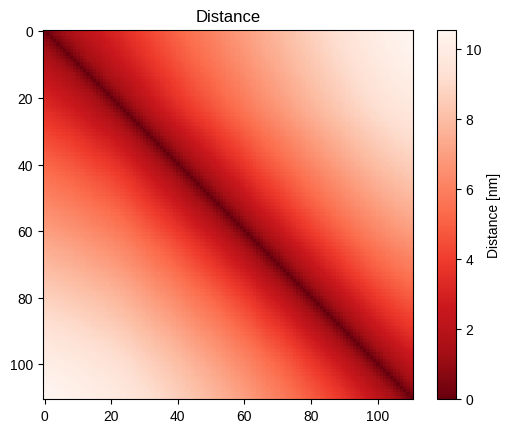

In [169]:
# Plotting distance contact map
plt.imshow(distances.mean(axis=0), cmap=plt.cm.get_cmap('Reds_r'))
plt.title("Distance")
plt.colorbar(label="Distance [nm]")

In [171]:
# Calculating interaction energies
energies = {
    'Ashbaugh-Hatch': 'AH',
    'Debye-Hückel': 'DH'#,
    #'Harmonic': 'HB'
}
for p, e in energies.items():
    energies[p] = analyse_utils.compute_energy(example.traj, potentials=[e])
    energies[p] = md.geometry.squareform(energies[p].T, example.traj.top.select_pairs('all','all'))

/tmp/ipykernel_19112/2330047340.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(e.mean(axis=0)*1000, vmin=-9, vmax=0, cmap=plt.cm.get_cmap('Reds_r'))


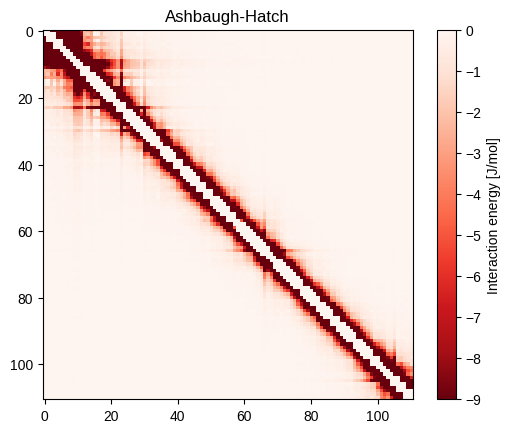

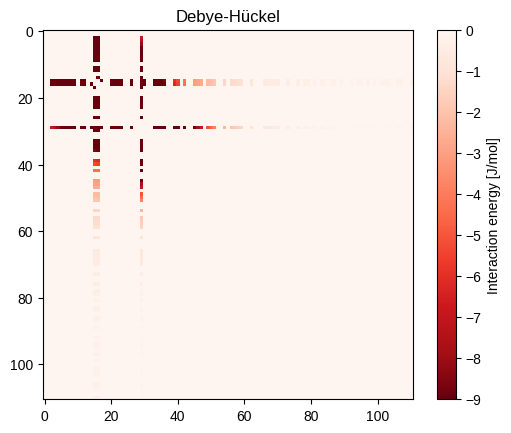

/tmp/ipykernel_19112/2330047340.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(sum(energies.values()).mean(axis=0)*1000, vmin=-9, vmax=0, cmap=plt.cm.get_cmap('Reds_r'))


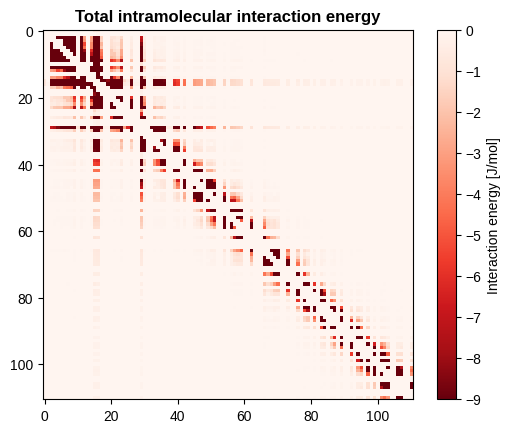

In [173]:
# Plotting energy contact maps
for p, e in energies.items():
    plt.imshow(e.mean(axis=0)*1000, vmin=-9, vmax=0, cmap=plt.cm.get_cmap('Reds_r'))
    plt.title(p)
    plt.colorbar(label="Interaction energy [J/mol]")
    plt.show()

plt.imshow(sum(energies.values()).mean(axis=0)*1000, vmin=-9, vmax=0, cmap=plt.cm.get_cmap('Reds_r'))
plt.title("Total intramolecular interaction energy", fontweight="bold")
plt.colorbar(label="Interaction energy [J/mol]")
plt.show()

### Drawing sequence

In [180]:
# Mapping sequence by charge
mapseq = []
for aa in example.sequence:
    if aa in ['D', 'E']:
        mapseq.append(-1)
    elif aa in ['K', 'R']:
        mapseq.append(1)
    else:
        mapseq.append(0)

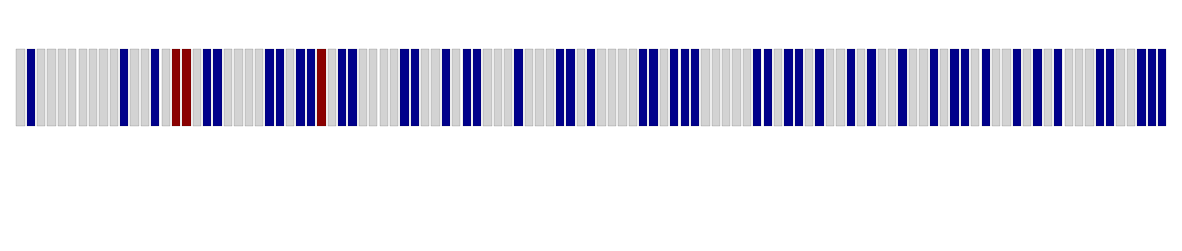

In [188]:
# Create a figure and axes object
fig, ax = plt.subplots(figsize=(15,3))

# Set the axis limits
ax.set_xlim([-1, len(mapseq)])
ax.set_ylim([-1.5, 1.5])

# Loop over the numbers and plot them as vertical bars
for i, num in enumerate(mapseq):
    color = {-1: 'darkred', 0: 'lightgrey', 1: 'darkblue'}[num]
    ax.bar(i, 1, color=color, edgecolor='black', linewidth=0.1,)

# Hide the ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Show the plot
plt.show()